In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:41375' processes=4 threads=4, memory=31.36 GiB>

In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [5]:
gridT_data_filesREF = "/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/5d/20*/*.5d_gridT*"
gridT_data_filesFUT = "/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-FUT08-MEAN/5d/20*/*.5d_gridT*"

grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"
# bathy_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc"

In [6]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [7]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

In [8]:
gridTREF = xr.decode_cf(xr.open_mfdataset(gridT_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

gridTREF = gridTREF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [9]:
gridTFUT = xr.decode_cf(xr.open_mfdataset(gridT_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

gridTFUT = gridTFUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [26]:
def map_config(ax):
    ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

In [11]:
gex = grid.e1t.squeeze()
gey = grid.e2t.squeeze()

In [12]:
mask_depth = mask.tmask.isel(x=slice(0,-1),y=slice(0,-1)).rename({'z':'deptht'}).squeeze()
mask_surf = mask.tmask.isel(x=slice(0,-1),y=slice(0,-1),z=0).squeeze()

In [13]:
dT_dx_REF = (gridTREF.votemper.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_REF = (gridTREF.votemper.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_REF = np.sqrt(dT_dx_REF**2 +  dT_dy_REF**2).assign_coords({"nav_lon":dT_dy_REF.nav_lon,"nav_lat":dT_dy_REF.nav_lat})

In [14]:
dT_dx_FUT = (gridTFUT.votemper.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_FUT = (gridTFUT.votemper.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_FUT = np.sqrt(dT_dx_FUT**2 +  dT_dy_FUT**2).assign_coords({"nav_lon":dT_dy_FUT.nav_lon,"nav_lat":dT_dy_FUT.nav_lat})

In [21]:
seasonal_temp_grad_REF = grad_mag_T_REF.groupby('time_counter.season').mean().compute()

In [22]:
seasonal_temp_grad_FUT = grad_mag_T_FUT.groupby('time_counter.season').mean().compute()

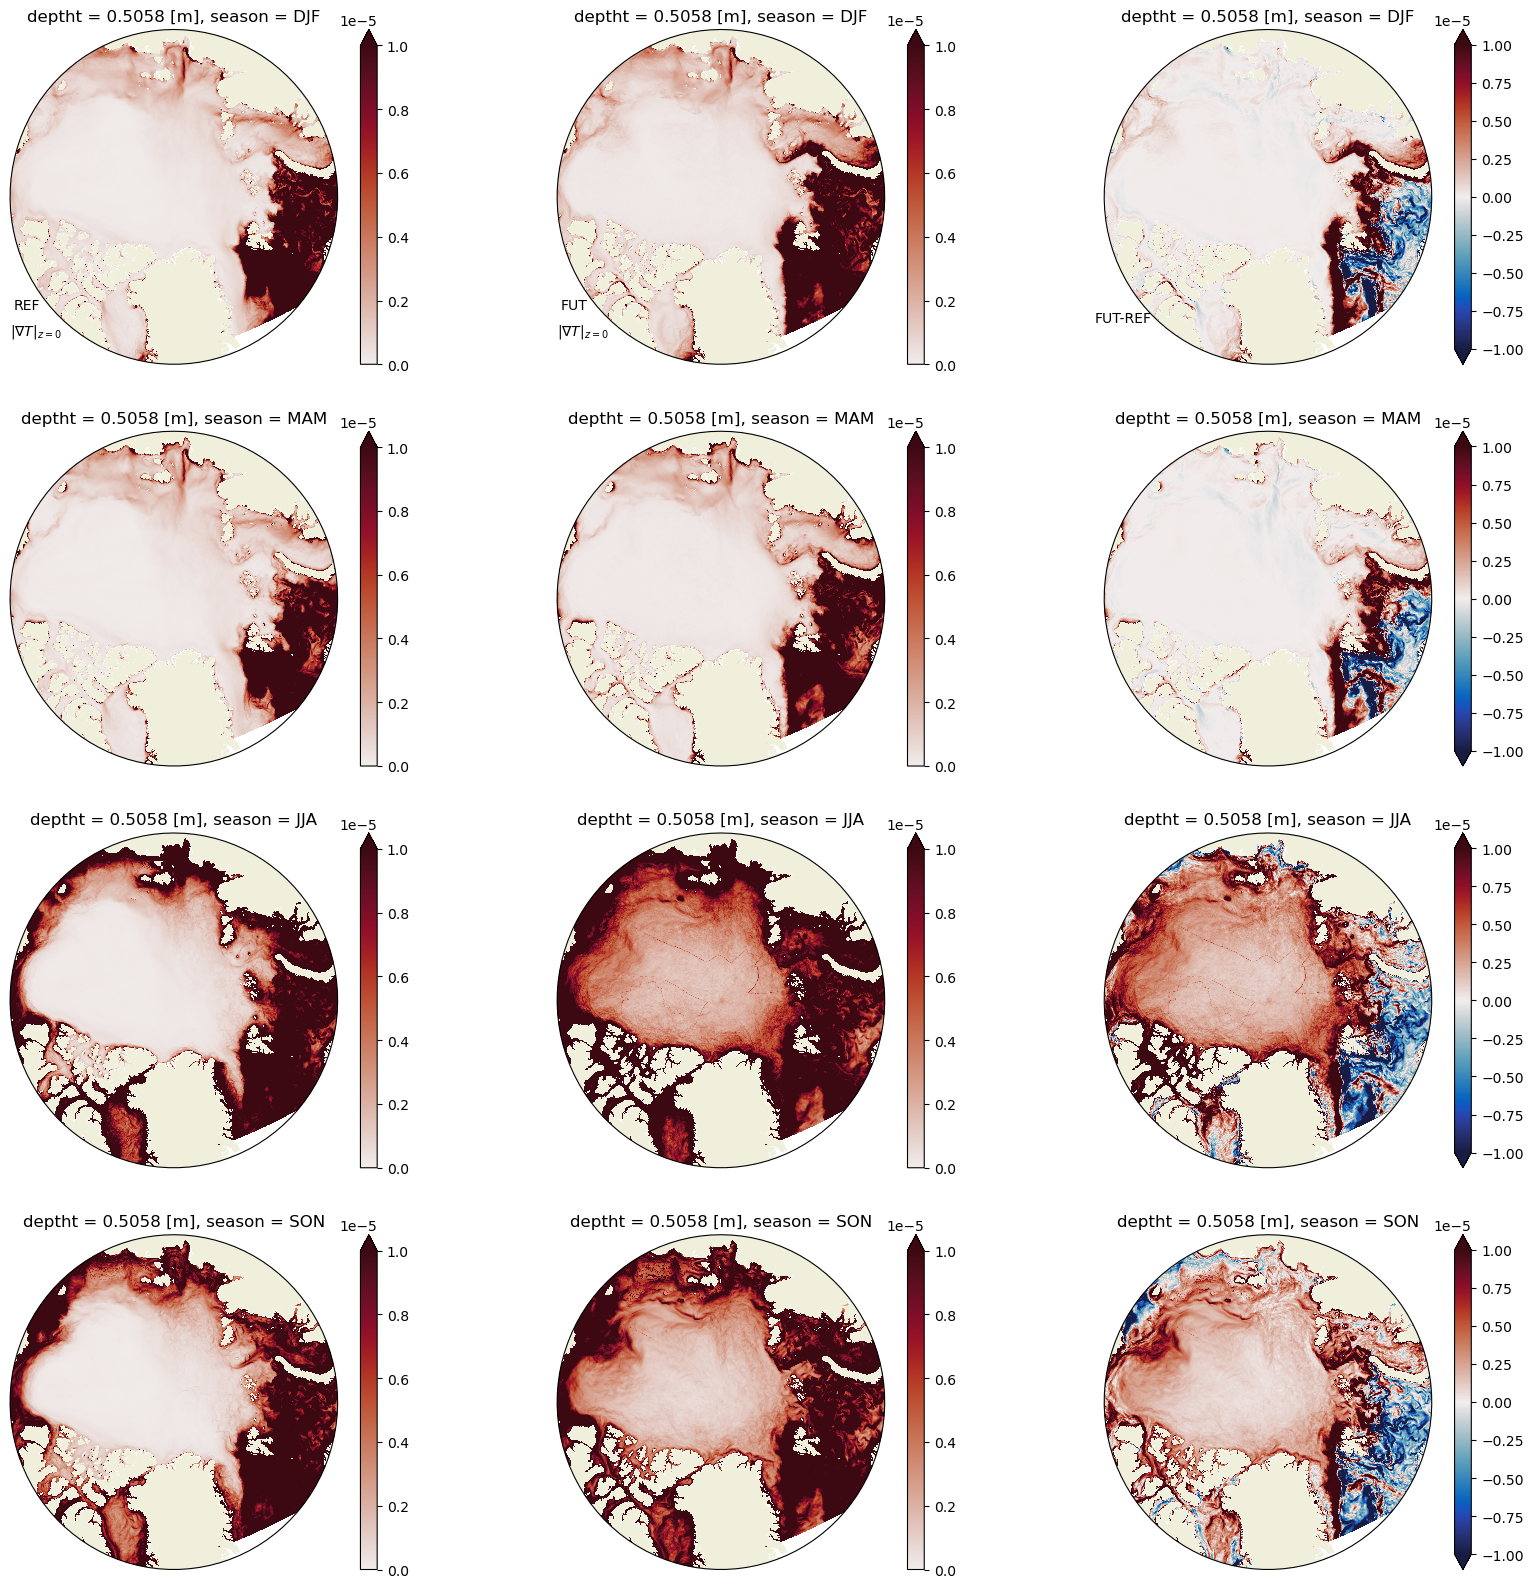

In [31]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(4, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(4, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(4, 3, 3, projection=ccrs.NorthPolarStereo(-45))

seasonal_temp_grad_REF.sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_temp_grad_FUT.sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_temp_grad_FUT-seasonal_temp_grad_REF).sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax4 = fig.add_subplot(4, 3, 4, projection=ccrs.NorthPolarStereo(-45))
ax5 = fig.add_subplot(4, 3, 5, projection=ccrs.NorthPolarStereo(-45))
ax6 = fig.add_subplot(4, 3, 6, projection=ccrs.NorthPolarStereo(-45))
seasonal_temp_grad_REF.sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax4, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_temp_grad_FUT.sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax5, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_temp_grad_FUT-seasonal_temp_grad_REF).sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax6, transform=ccrs.PlateCarree(),rasterized=True)

ax7 = fig.add_subplot(4, 3, 7, projection=ccrs.NorthPolarStereo(-45))
ax8 = fig.add_subplot(4, 3, 8, projection=ccrs.NorthPolarStereo(-45))
ax9 = fig.add_subplot(4, 3, 9, projection=ccrs.NorthPolarStereo(-45))
seasonal_temp_grad_REF.sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax7, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_temp_grad_FUT.sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax8, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_temp_grad_FUT-seasonal_temp_grad_REF).sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax9, transform=ccrs.PlateCarree(),rasterized=True)

ax10 = fig.add_subplot(4, 3, 10, projection=ccrs.NorthPolarStereo(-45))
ax11 = fig.add_subplot(4, 3, 11, projection=ccrs.NorthPolarStereo(-45))
ax12 = fig.add_subplot(4, 3, 12, projection=ccrs.NorthPolarStereo(-45))
seasonal_temp_grad_REF.sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax10, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_temp_grad_FUT.sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax11, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_temp_grad_FUT-seasonal_temp_grad_REF).sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax12, transform=ccrs.PlateCarree(),rasterized=True)



ax1.text(-90, 63, "REF\n\n\n", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$|\nabla T|_{z=0}$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$|\nabla T|_{z=0}$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]];

In [33]:
dS_dx_REF = (gridTREF.vosaline.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_REF = (gridTREF.vosaline.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_REF = np.sqrt(dS_dx_REF**2 +  dS_dy_REF**2).assign_coords({"nav_lon":dS_dy_REF.nav_lon,"nav_lat":dS_dy_REF.nav_lat})

In [34]:
dS_dx_FUT = (gridTFUT.vosaline.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_FUT = (gridTFUT.vosaline.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_FUT = np.sqrt(dS_dx_FUT**2 +  dS_dy_FUT**2).assign_coords({"nav_lon":dS_dy_FUT.nav_lon,"nav_lat":dS_dy_FUT.nav_lat})

In [35]:
seasonal_salt_grad_REF = grad_mag_S_REF.groupby('time_counter.season').mean().compute()

In [36]:
seasonal_salt_grad_FUT = grad_mag_S_FUT.groupby('time_counter.season').mean().compute()

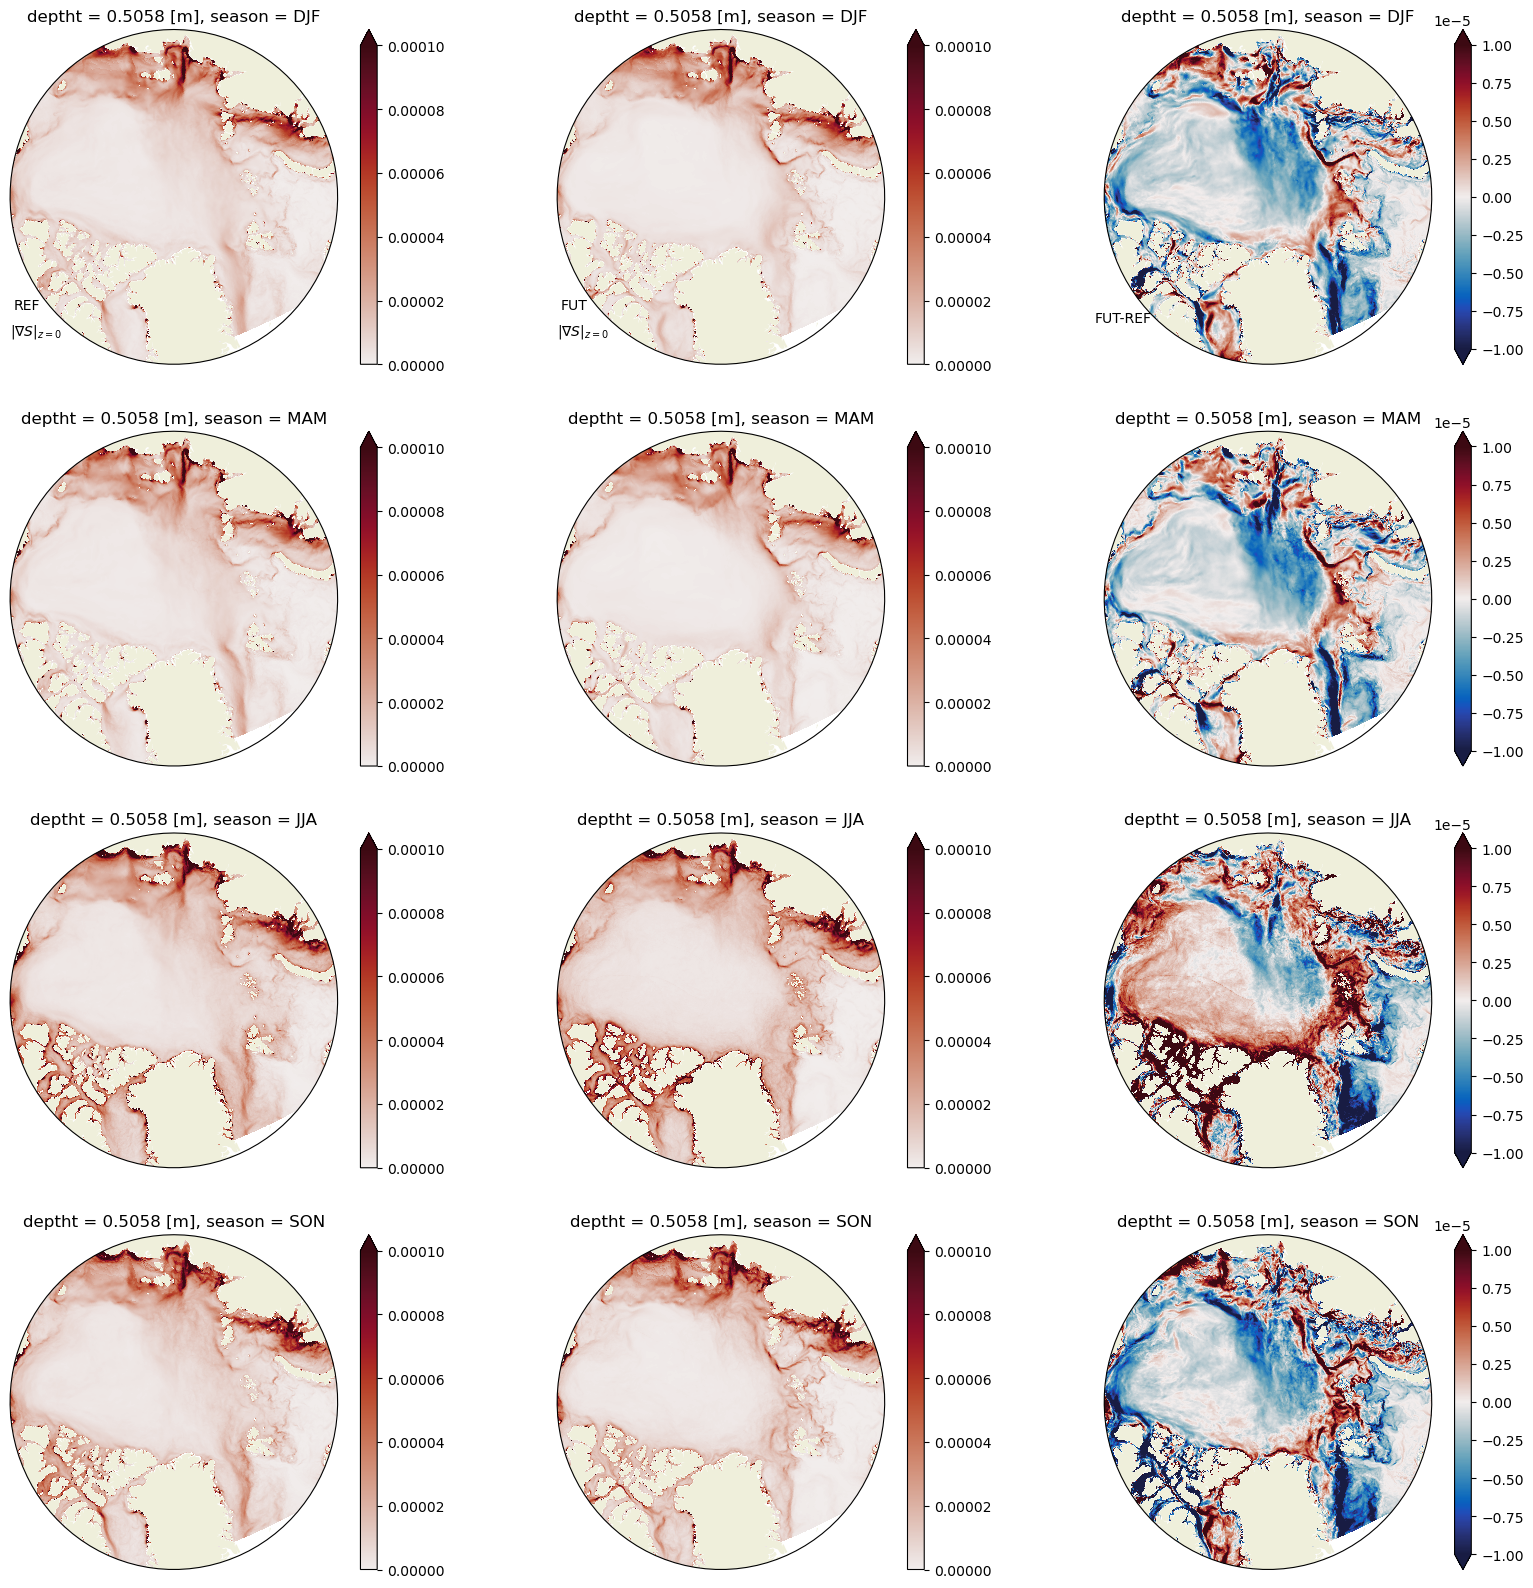

In [37]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(4, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(4, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(4, 3, 3, projection=ccrs.NorthPolarStereo(-45))

seasonal_salt_grad_REF.sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_salt_grad_FUT.sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_salt_grad_FUT-seasonal_salt_grad_REF).sel(season='DJF').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax4 = fig.add_subplot(4, 3, 4, projection=ccrs.NorthPolarStereo(-45))
ax5 = fig.add_subplot(4, 3, 5, projection=ccrs.NorthPolarStereo(-45))
ax6 = fig.add_subplot(4, 3, 6, projection=ccrs.NorthPolarStereo(-45))
seasonal_salt_grad_REF.sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax4, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_salt_grad_FUT.sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax5, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_salt_grad_FUT-seasonal_salt_grad_REF).sel(season='MAM').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax6, transform=ccrs.PlateCarree(),rasterized=True)

ax7 = fig.add_subplot(4, 3, 7, projection=ccrs.NorthPolarStereo(-45))
ax8 = fig.add_subplot(4, 3, 8, projection=ccrs.NorthPolarStereo(-45))
ax9 = fig.add_subplot(4, 3, 9, projection=ccrs.NorthPolarStereo(-45))
seasonal_salt_grad_REF.sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax7, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_salt_grad_FUT.sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax8, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_salt_grad_FUT-seasonal_salt_grad_REF).sel(season='JJA').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax9, transform=ccrs.PlateCarree(),rasterized=True)

ax10 = fig.add_subplot(4, 3, 10, projection=ccrs.NorthPolarStereo(-45))
ax11 = fig.add_subplot(4, 3, 11, projection=ccrs.NorthPolarStereo(-45))
ax12 = fig.add_subplot(4, 3, 12, projection=ccrs.NorthPolarStereo(-45))
seasonal_salt_grad_REF.sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax10, transform=ccrs.PlateCarree(),rasterized=True)
seasonal_salt_grad_FUT.sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax11, transform=ccrs.PlateCarree(),rasterized=True)
(seasonal_salt_grad_FUT-seasonal_salt_grad_REF).sel(season='SON').plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax12, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\n\n\n", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$|\nabla S|_{z=0}$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$|\nabla S|_{z=0}$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]];